In [2]:
import pandas as pd
import numpy as np
from os.path import exists
from tqdm import tqdm
from numba import jit
import matplotlib.pyplot as plt
import re
from collections import defaultdict, Counter
from multiprocessing import Pool, freeze_support
from itertools import repeat
from main import *

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

# Data
Load the Data

## Song informations

In [3]:
# genres
genres = pd.read_table("./../MMSR_WT22_Task2_Data/id_genres_mmsr.tsv", index_col="id")
# song infos (artist, song, album name)
info = pd.read_table("./../MMSR_WT22_Task2_Data/id_information_mmsr.tsv", index_col="id")

In [4]:
# convert genres to a list
genres['genre']= genres.genre.apply(lambda x: get_genres(x))

In [5]:
genres.head(1)

,genre
id,
0009fFIM1eYThaPg,[pop]


In [6]:
info.head(1)

,artist,song,album_name
id,,,
0009fFIM1eYThaPg,Cheryl,Rain on Me,3 Words


## Lyrics based features

In [7]:
# lyrics based feature vectors
tf_idf = pd.read_table("./../MMSR_WT22_Task2_Data/id_lyrics_tf-idf_mmsr.tsv", index_col="id")
word2vec = pd.read_table("./../MMSR_WT22_Task2_Data/id_lyrics_word2vec_mmsr.tsv", index_col='id')
bert = pd.read_table("./../MMSR_WT22_Task2_Data/id_lyrics_bert_mmsr.tsv", index_col='id')

In [8]:
tf_idf.head(1)

,abl,accept,across,act,addict,afraid,age,ago,ah,ahead,...,yea,yeah,year,yellow,yes,yesterday,yet,yo,young,youth
id,,,,,,,,,,,,,,,,,,,,,
9jbSytob9XRzwvB6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150511


In [9]:
word2vec.head(1)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
id,,,,,,,,,,,,,,,,,,,,,
0LiOzxBZ1aPLlFsK,0.031109,0.018026,0.022785,0.028802,-0.026084,-0.006278,0.030599,-0.041043,0.036703,0.034474,...,-0.025845,0.010468,-0.047819,0.00562,-0.025106,-0.017939,-0.009981,-0.027846,0.0211,-0.020994


In [10]:
bert.head(1)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
id,,,,,,,,,,,,,,,,,,,,,
9jbSytob9XRzwvB6,0.009225,0.041393,-0.003659,-0.0305,-0.006346,-0.019719,-0.075958,-0.003737,-0.000486,0.01122,...,-0.037228,-0.027013,0.029167,0.009537,-0.010819,0.004054,-0.018671,0.012545,0.020696,-0.019794


## Audio features

### [Low-level] Essentia

In [24]:
essentia = pd.read_table("./../MMSR_WT22_Task2_Data/id_essentia_mmsr.tsv", index_col="id")

In [25]:
essentia.head(1)

,lowlevel.average_loudness,lowlevel.barkbands.mean_0,lowlevel.barkbands.mean_1,lowlevel.barkbands.mean_2,lowlevel.barkbands.mean_3,lowlevel.barkbands.mean_4,lowlevel.barkbands.mean_5,lowlevel.barkbands.mean_6,lowlevel.barkbands.mean_7,lowlevel.barkbands.mean_8,...,tonal.thpcp_30,tonal.thpcp_31,tonal.thpcp_32,tonal.thpcp_33,tonal.thpcp_34,tonal.thpcp_35,tonal.tuning_diatonic_strength,tonal.tuning_equal_tempered_deviation,tonal.tuning_frequency,tonal.tuning_nontempered_energy_ratio
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.93353,0.00306,0.015665,0.004106,0.001265,0.001988,0.001152,0.000906,0.000356,0.001064,...,0.752843,0.54483,0.394721,0.37233,0.42242,0.855395,0.563373,0.226941,434.193115,0.944264


### [Mid-level] BLF: Block-Level features

In [15]:
# BLF: Block-Level features
blf_correlation = pd.read_table("./../MMSR_WT22_Task2_Data/id_blf_correlation_mmsr.tsv", index_col="id")
blf_deltaspectral = pd.read_table("./../MMSR_WT22_Task2_Data/id_blf_deltaspectral_mmsr.tsv", index_col='id')
blf_logfluc = pd.read_table("./../MMSR_WT22_Task2_Data/id_blf_logfluc_mmsr.tsv", index_col='id')
blf_spectral = pd.read_table("./../MMSR_WT22_Task2_Data/id_blf_spectral_mmsr.tsv", index_col='id')
blf_spectralcontrast = pd.read_table("./../MMSR_WT22_Task2_Data/id_blf_spectralcontrast_mmsr.tsv", index_col='id')
blf_vardeltaspectral = pd.read_table("./../MMSR_WT22_Task2_Data/id_blf_vardeltaspectral_mmsr.tsv", index_col='id')

In [26]:
blf_correlation.head(1)

,BLF_CORR0000,BLF_CORR0001,BLF_CORR0002,BLF_CORR0003,BLF_CORR0004,BLF_CORR0005,BLF_CORR0006,BLF_CORR0007,BLF_CORR0008,BLF_CORR0009,...,BLF_CORR1316,BLF_CORR1317,BLF_CORR1318,BLF_CORR1319,BLF_CORR1320,BLF_CORR1321,BLF_CORR1322,BLF_CORR1323,BLF_CORR1324,BLF_CORR1325
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.000321,0.000137,0.000113,0.000149,0.000155,0.000162,0.000103,0.000155,0.000171,0.000168,...,0.000653,0.000646,0.000598,0.000579,0.000683,0.000628,0.000619,0.000692,0.000638,0.000705


In [27]:
blf_deltaspectral.head(1)

,BLF_DELTASPEC0000,BLF_DELTASPEC0001,BLF_DELTASPEC0002,BLF_DELTASPEC0003,BLF_DELTASPEC0004,BLF_DELTASPEC0005,BLF_DELTASPEC0006,BLF_DELTASPEC0007,BLF_DELTASPEC0008,BLF_DELTASPEC0009,...,BLF_DELTASPEC1362,BLF_DELTASPEC1363,BLF_DELTASPEC1364,BLF_DELTASPEC1365,BLF_DELTASPEC1366,BLF_DELTASPEC1367,BLF_DELTASPEC1368,BLF_DELTASPEC1369,BLF_DELTASPEC1370,BLF_DELTASPEC1371
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.001393,0.001968,0.002798,0.00374,0.004487,0.005746,0.006643,0.007941,0.009872,0.011667,...,0.00205,0.002982,0.003977,0.004672,0.00602,0.008133,0.010676,0.013,0.016446,0.02429


In [28]:
blf_logfluc.head(1)

,ID,BLF_LOGFLUC0000,BLF_LOGFLUC0001,BLF_LOGFLUC0002,BLF_LOGFLUC0003,BLF_LOGFLUC0004,BLF_LOGFLUC0005,BLF_LOGFLUC0006,BLF_LOGFLUC0007,BLF_LOGFLUC0008,...,BLF_LOGFLUC3616,BLF_LOGFLUC3617,BLF_LOGFLUC3618,BLF_LOGFLUC3619,BLF_LOGFLUC3620,BLF_LOGFLUC3621,BLF_LOGFLUC3622,BLF_LOGFLUC3623,BLF_LOGFLUC3624,BLF_LOGFLUC3625
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,28.81,39.6568,40.0171,41.4088,52.5295,47.9892,56.4374,61.2276,44.0628,56.5137,...,242.485,238.565,311.603,285.56,259.526,457.302,214.001,185.704,162.142,NaN


In [29]:
blf_spectral.head(1)

,BLF_SPEC0000,BLF_SPEC0001,BLF_SPEC0002,BLF_SPEC0003,BLF_SPEC0004,BLF_SPEC0005,BLF_SPEC0006,BLF_SPEC0007,BLF_SPEC0008,BLF_SPEC0009,...,BLF_SPEC0970,BLF_SPEC0971,BLF_SPEC0972,BLF_SPEC0973,BLF_SPEC0974,BLF_SPEC0975,BLF_SPEC0976,BLF_SPEC0977,BLF_SPEC0978,BLF_SPEC0979
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,-0.02146,-0.01723,-0.013651,-0.010841,-0.008861,-0.00621,-0.004352,-0.002953,-0.001022,0.001472,...,-0.014418,-0.012594,-0.010883,-0.009404,-0.007405,-0.004714,-0.001504,0.001562,0.00228,0.003981


In [30]:
blf_spectralcontrast.head(1)

,BLF_SPEC_CTRS000,BLF_SPEC_CTRS001,BLF_SPEC_CTRS002,BLF_SPEC_CTRS003,BLF_SPEC_CTRS004,BLF_SPEC_CTRS005,BLF_SPEC_CTRS006,BLF_SPEC_CTRS007,BLF_SPEC_CTRS008,BLF_SPEC_CTRS009,...,BLF_SPEC_CTRS790,BLF_SPEC_CTRS791,BLF_SPEC_CTRS792,BLF_SPEC_CTRS793,BLF_SPEC_CTRS794,BLF_SPEC_CTRS795,BLF_SPEC_CTRS796,BLF_SPEC_CTRS797,BLF_SPEC_CTRS798,BLF_SPEC_CTRS799
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.019007,0.023217,0.024842,0.027076,0.028692,0.030983,0.032344,0.033264,0.033829,0.034378,...,0.019614,0.020961,0.021704,0.022956,0.023822,0.025027,0.025545,0.027219,0.028144,0.030365


In [31]:
blf_vardeltaspectral.head(1)

,BLF_VARDELTASPEC0000,BLF_VARDELTASPEC0001,BLF_VARDELTASPEC0002,BLF_VARDELTASPEC0003,BLF_VARDELTASPEC0004,BLF_VARDELTASPEC0005,BLF_VARDELTASPEC0006,BLF_VARDELTASPEC0007,BLF_VARDELTASPEC0008,BLF_VARDELTASPEC0009,...,BLF_VARDELTASPEC1334,BLF_VARDELTASPEC1335,BLF_VARDELTASPEC1336,BLF_VARDELTASPEC1337,BLF_VARDELTASPEC1338,BLF_VARDELTASPEC1339,BLF_VARDELTASPEC1340,BLF_VARDELTASPEC1341,BLF_VARDELTASPEC1342,BLF_VARDELTASPEC1343
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.004883,0.004828,0.004785,0.004839,0.004948,0.004955,0.005105,0.005192,0.005366,0.005388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001486


### [Mid-level] MFCC: Mel Frequency Cepstral Coefficients

In [32]:
mfcc_bow = pd.read_table("./../MMSR_WT22_Task2_Data/id_mfcc_bow_mmsr.tsv", index_col='id')
mfcc_stats = pd.read_table("./../MMSR_WT22_Task2_Data/id_mfcc_stats_mmsr.tsv", index_col='id')

In [33]:
mfcc_bow.head(1)

,mfccB000,mfccB001,mfccB002,mfccB003,mfccB004,mfccB005,mfccB006,mfccB007,mfccB008,mfccB009,...,mfccB490,mfccB491,mfccB492,mfccB493,mfccB494,mfccB495,mfccB496,mfccB497,mfccB498,mfccB499
id,,,,,,,,,,,,,,,,,,,,,
ec73R8NdbZIZkrfL,0.60206,0.0,1.908485,0.0,1.544068,0.0,2.075547,1.20412,0.0,1.0,...,0.954242,0.30103,0.60206,1.70757,2.472756,2.326336,0.0,1.886491,0.954242,2.292256


In [34]:
mfcc_stats.head(1)

,MFCC000,MFCC001,MFCC002,MFCC003,MFCC004,MFCC005,MFCC006,MFCC007,MFCC008,MFCC009,...,cov_9_9,cov_9_10,cov_9_11,cov_9_12,cov_10_10,cov_10_11,cov_10_12,cov_11_11,cov_11_12,cov_12_12
id,,,,,,,,,,,,,,,,,,,,,
9epP1yOXfLKlkR3S,24.351542,-16.61149,-10.792922,0.983246,-4.003687,-0.180248,-1.510487,-0.66313,2.915891,-0.746395,...,57.688839,20.511395,3.479626,-1.560816,63.036257,26.379835,2.551358,55.18889,18.194372,52.472903


## Video features

In [35]:
incp = pd.read_table("./../MMSR_WT22_Task2_Data/id_incp_mmsr.tsv", index_col='id')
resnet = pd.read_table("./../MMSR_WT22_Task2_Data/id_resnet_mmsr.tsv", index_col='id')
vgg19 = pd.read_table("./../MMSR_WT22_Task2_Data/id_vgg19_mmsr.tsv", index_col='id')

In [36]:
incp.head(1)

,max0000,max0001,max0002,max0003,max0004,max0005,max0006,max0007,max0008,max0009,...,mean2038,mean2039,mean2040,mean2041,mean2042,mean2043,mean2044,mean2045,mean2046,mean2047
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.100504,0.21715,1.109056,0.281565,0.169181,0.060095,0.112506,0.392196,0.239908,0.43433,...,0.650006,1.251627,0.040662,0.587215,0.047169,0.349248,0.130577,0.113338,0.679946,0.222986


In [37]:
resnet.head(1)

,max0000,max0001,max0002,max0003,max0004,max0005,max0006,max0007,max0008,max0009,...,mean2038,mean2039,mean2040,mean2041,mean2042,mean2043,mean2044,mean2045,mean2046,mean2047
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.757878,0.372375,0.021445,0.134415,0.042789,0.0,2.265696,0.695247,0.0,0.917684,...,0.720582,1.061841,0.060057,0.0,0.208763,0.610948,0.188767,1.879605,0.210793,0.412322


In [38]:
vgg19.head(1)

,max0000,max0001,max0002,max0003,max0004,max0005,max0006,max0007,max0008,max0009,...,mean4086,mean4087,mean4088,mean4089,mean4090,mean4091,mean4092,mean4093,mean4094,mean4095
id,,,,,,,,,,,,,,,,,,,,,
0009fFIM1eYThaPg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.74753,...,0.0,0.0,0.0,0.0,0.0,0.0,2.071867,0.0,1.022306,0.0


# Genre Statistics

In [222]:
# first lets create a dictionary and count all appearing genres
# creating dictionary
genre_frequencies = defaultdict(int)
all_genres = genres.genre
for song in all_genres:
    for genre in song:
        genre_frequencies[genre] += 1
dictionary_genres = pd.DataFrame(genre_frequencies, index=[0]).T
dictionary_genres.columns = ['Frequency']
# sort it
dictionary_genres.sort_values(by=['Frequency'], ascending=False, inplace=True)
original_dict_size = len(dictionary_genres)
dictionary_genres

,Frequency
rock,33912
pop,28841
alternative rock,17147
indie rock,11997
singer songwriter,10935
...,...
indie jazz,1
rap metalcore,1
atmospheric dnb,1
hungarian rock,1


In [228]:
# count of genres which have only 1 song
(dictionary_genres < 2).value_counts()

Frequency
False        1363
True          307
dtype: int64

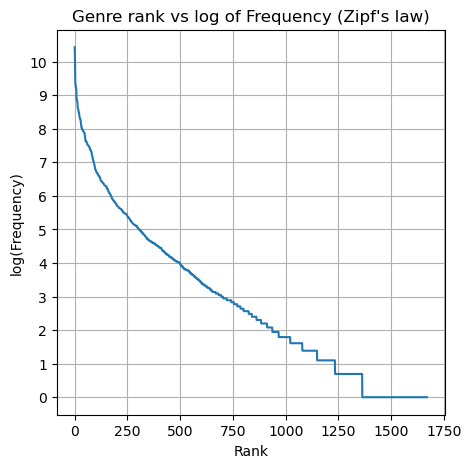

In [223]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(np.arange(len(dictionary_genres)), [np.log(f) for f in dictionary_genres['Frequency']])
ax.set_xlabel('Rank')
ax.set_ylabel('log(Frequency)')
ax.set_yticks(np.arange(11))
ax.set_title('Genre rank vs log of Frequency (Zipf\'s law)')
ax.grid(True)
plt.savefig('./plots/genre_rang_vs_freq.png',bbox_inches='tight')

dictionary size: 1670



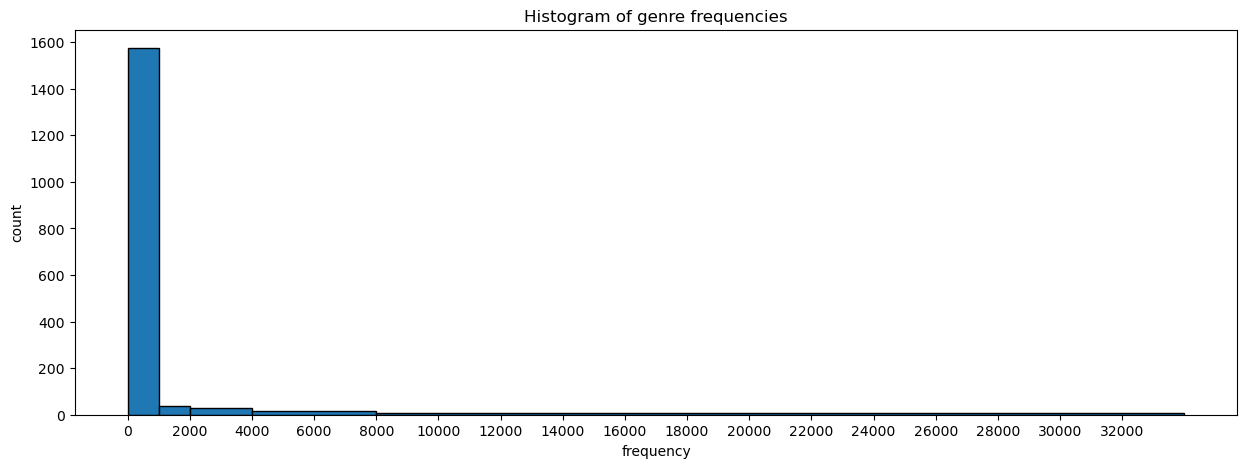

In [193]:
max_frequency_rounded =  round(dictionary_genres['Frequency'][0], -3)
bins = [0, 1000, 2000, 4000, 8000, max_frequency_rounded]
# statistics before cut off
print(f'dictionary size: {original_dict_size}\n')

fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharey=True)
axs.hist(dictionary_genres['Frequency'], bins=bins,edgecolor='black', linewidth=1.0)
#axs.set_ylim(0, 100) 
axs.set_xticks(np.arange(0,max_frequency_rounded,2000))
axs.set_title('Histogram of genre frequencies')
axs.set_xlabel('frequency')
axs.set_ylabel('count')
axs.grid(False)
plt.savefig('./plots/histo_genre_freq.png',bbox_inches='tight')

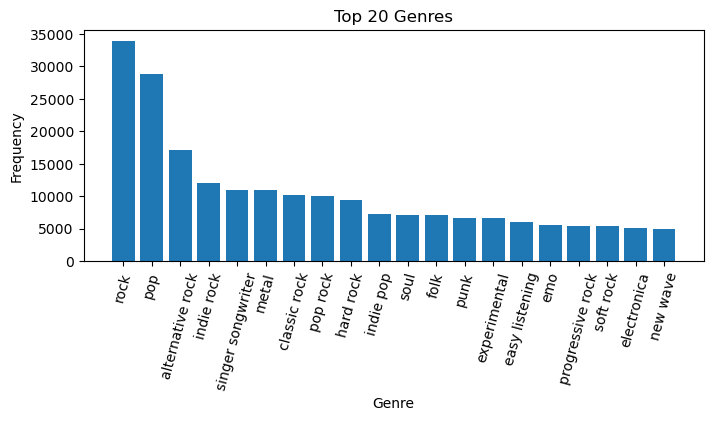

In [229]:
show_n = 20
fig, axs = plt.subplots(1, 1, figsize=(8, 3), sharey=True)
axs.bar(list(dictionary_genres.index)[:show_n], dictionary_genres['Frequency'][:show_n])
axs.set_title('Top 20 Genres')
axs.set_xlabel('Genre')
axs.set_ylabel('Frequency')
axs.tick_params(axis='x', labelrotation=75)
axs.grid(False)
plt.savefig('./plots/top20genres.png',bbox_inches='tight')

In [119]:
# count genres for each song
genres['n_genres']= genres.genre.apply(lambda x: len(x))
# get average number of genres
genres['n_genres'].mean()

7.176279483107764

In [149]:
# average number of tracks that share one genre
dictionary_genres.Frequency.mean()

294.9622754491018

In [163]:
# most common words in lyrics
common_words = tf_idf.sum().sort_values(ascending=False)

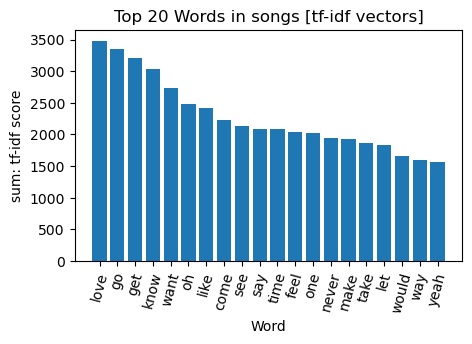

In [202]:
show_n = 20
fig, axs = plt.subplots(1, 1, figsize=(5, 3), sharey=True)
axs.bar(list(common_words.index)[:show_n], common_words[:show_n])
axs.set_title('Top 20 Words in songs [tf-idf vectors]')
axs.set_xlabel('Word')
axs.set_ylabel('sum: tf-idf score')
axs.tick_params(axis='x', labelrotation=75)
axs.grid(False)
plt.savefig('./plots/lyrics_top20words.png',bbox_inches='tight')

# Feature statistics

In [245]:
def get_song_by_genre(genre:str, data:pd.DataFrame):
    # return song_ids which the genre fit
    songs = []
    index = data.index.to_list()
    for i, s in enumerate(data.genre):
        if genre in s:
            songs.append(index[i])
    return songs

In [262]:
songs_gen1 = get_song_by_genre('metal', genres)
songs_gen2 = get_song_by_genre('soul', genres)

In [263]:
gen1 = essentia.loc[songs_gen1]
gen1.mean()

lowlevel.average_loudness                  0.954720
lowlevel.barkbands.mean_0                  0.000521
lowlevel.barkbands.mean_1                  0.009539
lowlevel.barkbands.mean_2                  0.005177
lowlevel.barkbands.mean_3                  0.002779
                                            ...    
tonal.thpcp_35                             0.741682
tonal.tuning_diatonic_strength             0.563986
tonal.tuning_equal_tempered_deviation      0.162690
tonal.tuning_frequency                   438.592018
tonal.tuning_nontempered_energy_ratio      0.830550
Length: 1034, dtype: float64

In [264]:
gen2 = essentia.loc[songs_gen2]
gen2.mean()

lowlevel.average_loudness                  0.923373
lowlevel.barkbands.mean_0                  0.000721
lowlevel.barkbands.mean_1                  0.009442
lowlevel.barkbands.mean_2                  0.003448
lowlevel.barkbands.mean_3                  0.001957
                                            ...    
tonal.thpcp_35                             0.705236
tonal.tuning_diatonic_strength             0.596303
tonal.tuning_equal_tempered_deviation      0.150675
tonal.tuning_frequency                   438.694964
tonal.tuning_nontempered_energy_ratio      0.816796
Length: 1034, dtype: float64